In [246]:
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.optimize import curve_fit
import numpy as np

In [247]:
pkl_path = "flowstats_ra.pkl"

with open(pkl_path, "rb") as f:
    flowstats = pkl.load(f)

print(f"Loaded Ra runs: {list(flowstats.keys())}")

Loaded Ra runs: ['500', '1000', '750', '1500', '2000', '4000', '8000', '16000', '32000', '64000', '128000', '256000', '512000', '1000000']


In [248]:
# CONFIGURATION for plotting
last_steps = 100

In [249]:
Ra_values = []
Nu_max_values = []
Nu_mean_values = []
Nu_std_values = []
vz_max_mean_values = []
vz_max_max_values = []
vz_max_std_values = []

for ra_str, stats in flowstats.items():
    Ra_values.append(float(ra_str))
    
    nu_steps = stats["nusselt_step"]
    # nusselt_step is a list or array per time step → choose mean or last
    nu_val_mean = nu_steps[-last_steps:].mean()  # calculate mean over last steps
    nu_val_std = nu_steps[-last_steps:].std()
    nu_val_max = nu_steps[-last_steps:].max()

    Nu_mean_values.append(nu_val_mean)
    Nu_std_values.append(nu_val_std)
    Nu_max_values.append(nu_val_max)

    vz_max_steps = stats["uz_max_step"]
    # vz_max_steps = np.sqrt(stats["uv_max_step"]**2 + stats["uw_max_step"]**2 + stats["uz_max_step"]**2)  # calculate magnitude of velocity vector
    vz_mean = vz_max_steps[-last_steps:].mean()  # calculate mean over last steps
    vz_max = vz_max_steps[-last_steps:].max()  # or mean
    vz_std = vz_max_steps[-last_steps:].std()

    vz_max_mean_values.append(vz_mean)
    vz_max_max_values.append(vz_max)
    vz_max_std_values.append(vz_std)

# Sort by Ra for nice plots
Ra_values, Nu_max_values, Nu_mean_values, Nu_std_values, vz_max_mean_values, vz_max_max_values, vz_max_std_values = zip(*sorted(zip(Ra_values, Nu_max_values, Nu_mean_values, Nu_std_values, vz_max_mean_values, vz_max_max_values, vz_max_std_values)))
Ra_values = np.array(Ra_values); Nu_max_values = np.array(Nu_max_values); Nu_mean_values = np.array(Nu_mean_values);
Nu_std_values = np.array(Nu_std_values); vz_max_mean_values = np.array(vz_max_mean_values); vz_max_max_values = np.array(vz_max_max_values)
vz_max_std_values = np.array(vz_max_std_values)

In [250]:
# Curvefitting for the relationships between Ra and Nu, vz_max
def func_nu_ra(x, a, b):
    # from the literature, we know that Nu ~ Ra^b
    # where b is typically around 1/3 for turbulent convection
    return a * x ** b

# def func_u_ra(x, k, w):
#     return w * (1 - np.exp(-k * x))
# popt_vz, pcov_vz = curve_fit(func_u_ra, Ra_values, vz_max_max_values, (1e-5, 0.9))

# def func_u_ra(x, a, n, b):
#     return a * (x ** n / (x ** n + b))

def func_u_ra(Ra, w_inf, Ra_c, n):
    return w_inf * Ra**n / (Ra**n + Ra_c**n)


popt, pcov = curve_fit(func_nu_ra, Ra_values, Nu_max_values)
popt_vz, pcov_vz = curve_fit(func_u_ra, Ra_values, vz_max_max_values, p0=p0, bounds=((0, 0, 0),(np.inf, np.inf, np.inf)))

print(popt)
print(popt_vz)
func_u_ra(Ra_values, *popt_vz)

[0.22935057 0.27157117]
[  0.96110603 647.36505318   1.07038408]


array([0.41454071, 0.51832349, 0.5904137 , 0.6831901 , 0.73989392,
       0.84132561, 0.90008395, 0.93104814, 0.94655432, 0.95412122,
       0.95776721, 0.95951321, 0.96034688, 0.96073508])

In [251]:
Ra_values

array([5.00e+02, 7.50e+02, 1.00e+03, 1.50e+03, 2.00e+03, 4.00e+03,
       8.00e+03, 1.60e+04, 3.20e+04, 6.40e+04, 1.28e+05, 2.56e+05,
       5.12e+05, 1.00e+06])

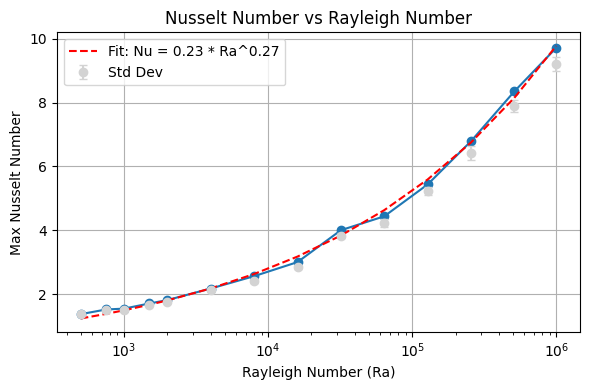

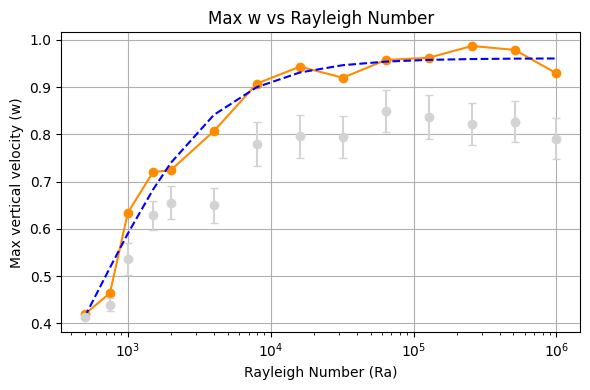

In [252]:
# ---------- Plot Nu vs Ra ----------
plt.figure(figsize=(6,4))
plt.plot(Ra_values, Nu_max_values, marker='o')
plt.errorbar(Ra_values, Nu_mean_values, yerr=Nu_std_values, fmt='o', color='lightgray', capsize=3, label='Std Dev')
plt.plot(Ra_values, func_nu_ra(Ra_values, *popt), color='red', linestyle='--', label=f'Fit: Nu = {popt[0]:.2f} * Ra^{popt[1]:.2f}')
plt.xscale("log")
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Max Nusselt Number")
plt.title("Nusselt Number vs Rayleigh Number")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot vz_max vs Ra ----------
plt.figure(figsize=(6,4))
plt.plot(Ra_values, vz_max_max_values, marker='o', color='darkorange')
plt.errorbar(Ra_values, vz_max_mean_values, yerr=vz_max_std_values, fmt='o', color='lightgray', capsize=3, label='Std Dev')
plt.plot(Ra_values, func_u_ra(Ra_values, *popt_vz), color='blue', linestyle='--')
plt.xscale("log")
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Max vertical velocity (w)")
plt.title("Max w vs Rayleigh Number")
plt.grid(True)
plt.tight_layout()
plt.show()

In [253]:
np.sqrt(2)

np.float64(1.4142135623730951)